# Clustering Analysis (Shooting Percentages)

## Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import sklearn
from sklearn.cluster import KMeans
import sklearn.metrics as sm
from sklearn import datasets
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import scale
from scipy.cluster.hierarchy import dendrogram, linkage
%matplotlib inline

## Import Excel Data

In [2]:
map = {}

# Loading Excel Data and adding each sheet into a map with its respective data
xls = pd.ExcelFile('nba_draft.xlsx')
for sheet_name in xls.sheet_names:
    map[sheet_name] = xls.parse(sheet_name)

## Initialize Parameters

In [3]:
# Define number of clusters (K)
num_clusters = 3

# Define the maximum draft pick number to be included in the analysis
max_draft_selection = 60

# Define the positions of interest
positions = ['Center', 'Center/Forward', 'Forward/Center']

# Define start year of draft class range
start_year = 1990

# Define end year of draft class range
end_year = 2020

# Define color theme for scatter plots
color_theme = np.array(['red','blue','green', 'yellow', 'orange'])

## Clean, Partition, Transform Data 

In [4]:
df = []

# Concatenate all sheets in draft class range 
for i in range(start_year, end_year):
    df.append(map['draft_data_{}'.format(i)])
percentages_df = pd.concat(df)

# Filter draft picks
percentages_df = percentages_df[percentages_df['Pk']  <= max_draft_selection]
    
    
# Filter positions of interest
if len(positions) != 0:
    percentages_df = percentages_df[percentages_df['position'].isin(positions)]

# Filter out outliers
percentages_df = percentages_df[percentages_df['college_3P%'] < 1]

# Get columns of interest 
sg_df = percentages_df.iloc[:, 37:-12]
sg_df_with_years = percentages_df.iloc[:, list(range(37,40)) + [-3]]

# Drop null rows
sg_df = sg_df.dropna()
sg_df_with_years = sg_df_with_years.dropna()

# Perform K-means clustering and define feature variables 
data = sg_df.to_numpy()
clustering  = KMeans(n_clusters=num_clusters,random_state=5)
clustering.fit(data)
sg_df.columns = ['FG','threePointPercentage','FT']

## Elbow Method

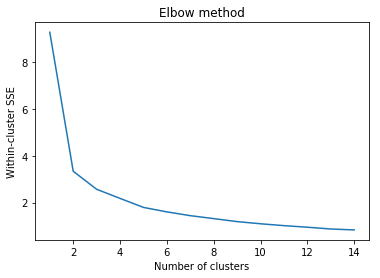

In [5]:
# Execute elbow method to determine optimal K value
distortations = {}
for k in range(1,15):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(sg_df)
  distortations[k] = kmeans.inertia_

plt.plot(list(distortations.keys()),list(distortations.values()))
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster SSE')
plt.show()

## Clustering Output (2D Plots)

Clusters: [[0.55305376 0.01567742 0.62235484]
 [0.53386842 0.39265789 0.71665789]
 [0.537875   0.2665     0.65486364]]


red: Cluster 0
blue: Cluster 1
green: Cluster 2


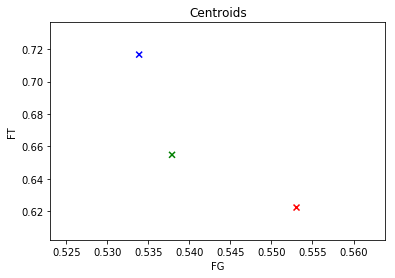

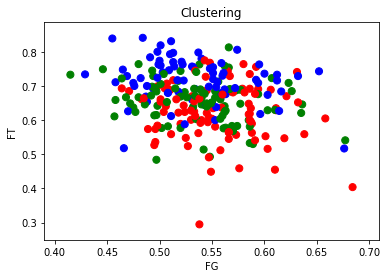

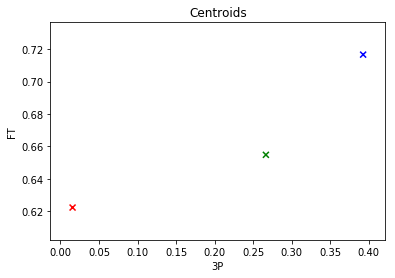

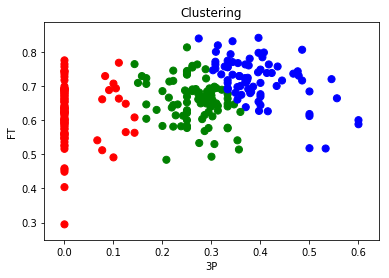

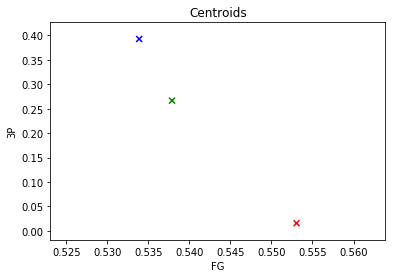

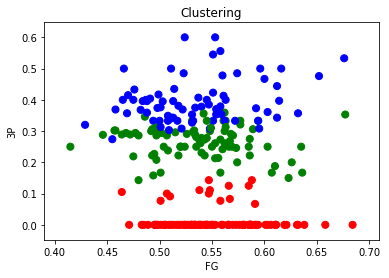

In [6]:
centroids = clustering.cluster_centers_
print('Clusters: {}'.format(centroids))
print('\n')
t = np.arange(num_clusters)
for i in range(len(centroids)):
    print('{}: Cluster {}'.format(color_theme[i], i))

# Show centroid data in scatter plot for FG% vs FT%
plt.scatter(centroids[:,0], centroids[:,2], marker="x", c=color_theme[t])
plt.title('Centroids')
plt.xlabel('FG')
plt.ylabel('FT')
plt.show()

# Show clustering results in scatter plot for FG% vs FT%
plt.scatter(x=sg_df.FG,y=sg_df.FT,c=color_theme[clustering.labels_],s=50)
plt.title('Clustering')
plt.xlabel('FG')
plt.ylabel('FT')
plt.show()

# Show centroid data in scatter plot for 3P% vs FT%
plt.scatter(centroids[:,1], centroids[:,2], marker="x", c=color_theme[t])
plt.title('Centroids')
plt.xlabel('3P')
plt.ylabel('FT')
plt.show()

# Show clustering results in scatter plot for 3P% vs FT%
plt.scatter(x=sg_df.threePointPercentage,y=sg_df.FT,c=color_theme[clustering.labels_],s=50)
plt.title('Clustering')
plt.xlabel('3P')
plt.ylabel('FT')
plt.show()

# Show centroid data in scatter plot for FG% vs 3P%
plt.scatter(centroids[:,0], centroids[:,1], marker="x", c=color_theme[t])
plt.title('Centroids')
plt.xlabel('FG')
plt.ylabel('3P')
plt.show()

# Show clustering results in scatter plot for FG% vs 3P%
plt.scatter(x=sg_df.FG,y=sg_df.threePointPercentage,c=color_theme[clustering.labels_],s=50)
plt.title('Clustering')
plt.xlabel('FG')
plt.ylabel('3P')
plt.show()

## Clustering Output (3D Plots)

Clusters: [[0.55305376 0.01567742 0.62235484]
 [0.53386842 0.39265789 0.71665789]
 [0.537875   0.2665     0.65486364]]


red: Cluster 0
blue: Cluster 1
green: Cluster 2


Text(0.5, 0, 'FT%')

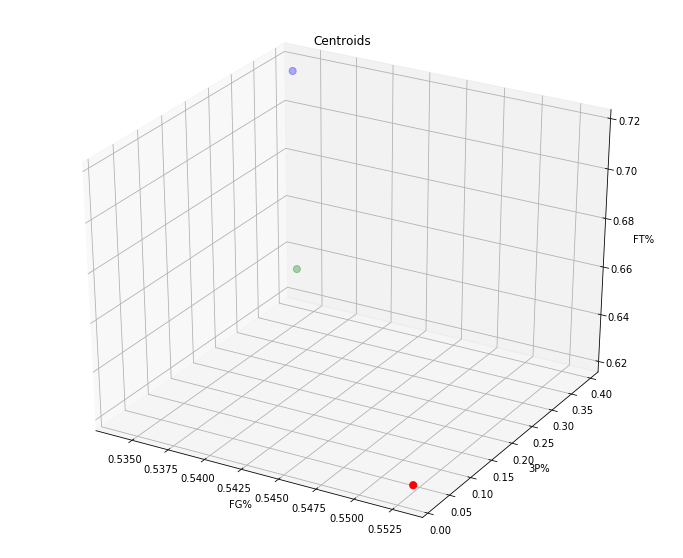

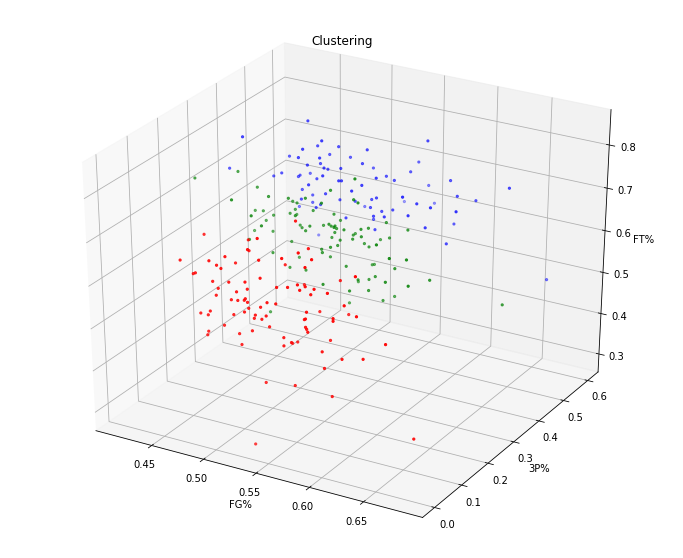

In [7]:
centroids = clustering.cluster_centers_
print('Clusters: {}'.format(centroids))
print('\n')
t = np.arange(num_clusters)
for i in range(len(centroids)):
    print('{}: Cluster {}'.format(color_theme[i], i))

# Show centroid data in 3D scatter plot
fig = plt.figure(figsize=(12,10))
centroid_3d = fig.add_subplot(111, projection='3d')
centroid_3d.scatter(xs=centroids[:,0],ys=centroids[:,1], zs = centroids[:,2], s=50, label=sg_df.columns, c=color_theme[t])
centroid_3d.set_title('Centroids')
centroid_3d.set_xlabel('FG%')
centroid_3d.set_ylabel('3P%')
centroid_3d.set_zlabel('FT%')

# Show clustering results in 3D scatter plot
fig2 = plt.figure(figsize=(12,10))
ax = fig2.add_subplot(111, projection='3d')
ax.scatter(xs=sg_df.FG, ys=sg_df.threePointPercentage, zs = sg_df.FT, label=sg_df.columns, c=color_theme[clustering.labels_],s=5)
ax.set_title('Clustering')
ax.set_xlabel('FG%')
ax.set_ylabel('3P%')
ax.set_zlabel('FT%')


##  Clustering Output Aggregations

In [8]:
# Aggregate clustering result, group by cluster and count rows
cluster_counts = {}
for i in range(len(clustering.labels_)):
    if clustering.labels_[i] not in cluster_counts:
        cluster_counts[clustering.labels_[i]] = 1
    else:
        cluster_counts[clustering.labels_[i]] += 1
print('In Total:')
for i in cluster_counts:
    print('{} players were drafted in the top {} picks of their respective draft that fall in cluster {}'.format(cluster_counts[i], max_draft_selection, i))
print('Sum: {}'.format(sum(cluster_counts.values())))
print('\n')

# Further group cluster by decade 
decade_counts = {1990: {}, 2000: {}, 2010: {}}
for i in range(num_clusters):  
    decade_counts[1990.0][i] = 0
    decade_counts[2000.0][i] = 0
    decade_counts[2010.0][i] = 0

for i in range(len(clustering.labels_)):
    if (1990.0 <= sg_df_with_years.iloc[i][3] < 2000.0):  
        decade_counts[1990][clustering.labels_[i]] += 1
    elif (2000.0 <= sg_df_with_years.iloc[i][3] < 2010.0):  
        decade_counts[2000][clustering.labels_[i]] += 1
    elif (2010.0 <= sg_df_with_years.iloc[i][3] < 2020.0):  
        decade_counts[2010][clustering.labels_[i]] += 1
        
# Output aggregations calculated for each year by cluster
# Including percentage of each cluster count for given decade and total sum of prospects in each decade    
for i in decade_counts:
    print('In the {}\'s'.format(i))
    for j in decade_counts[i]:
        percentage = str(decade_counts[i][j]/sum(decade_counts[i].values()))[:5]
        print('    ({}) {} players were drafted in the top {} picks of their respective draft that fall in cluster {}'.format(percentage, decade_counts[i][j],max_draft_selection,  j))
    print('Sum: {}'.format(sum(decade_counts[i].values())))
    print('\n')

In Total:
88 players were drafted in the top 60 picks of their respective draft that fall in cluster 2
93 players were drafted in the top 60 picks of their respective draft that fall in cluster 0
76 players were drafted in the top 60 picks of their respective draft that fall in cluster 1
Sum: 257


In the 1990's
    (0.490) 50 players were drafted in the top 60 picks of their respective draft that fall in cluster 0
    (0.205) 21 players were drafted in the top 60 picks of their respective draft that fall in cluster 1
    (0.303) 31 players were drafted in the top 60 picks of their respective draft that fall in cluster 2
Sum: 102


In the 2000's
    (0.320) 25 players were drafted in the top 60 picks of their respective draft that fall in cluster 0
    (0.320) 25 players were drafted in the top 60 picks of their respective draft that fall in cluster 1
    (0.358) 28 players were drafted in the top 60 picks of their respective draft that fall in cluster 2
Sum: 78


In the 2010's
    (0.

##  Cluster Dendogram

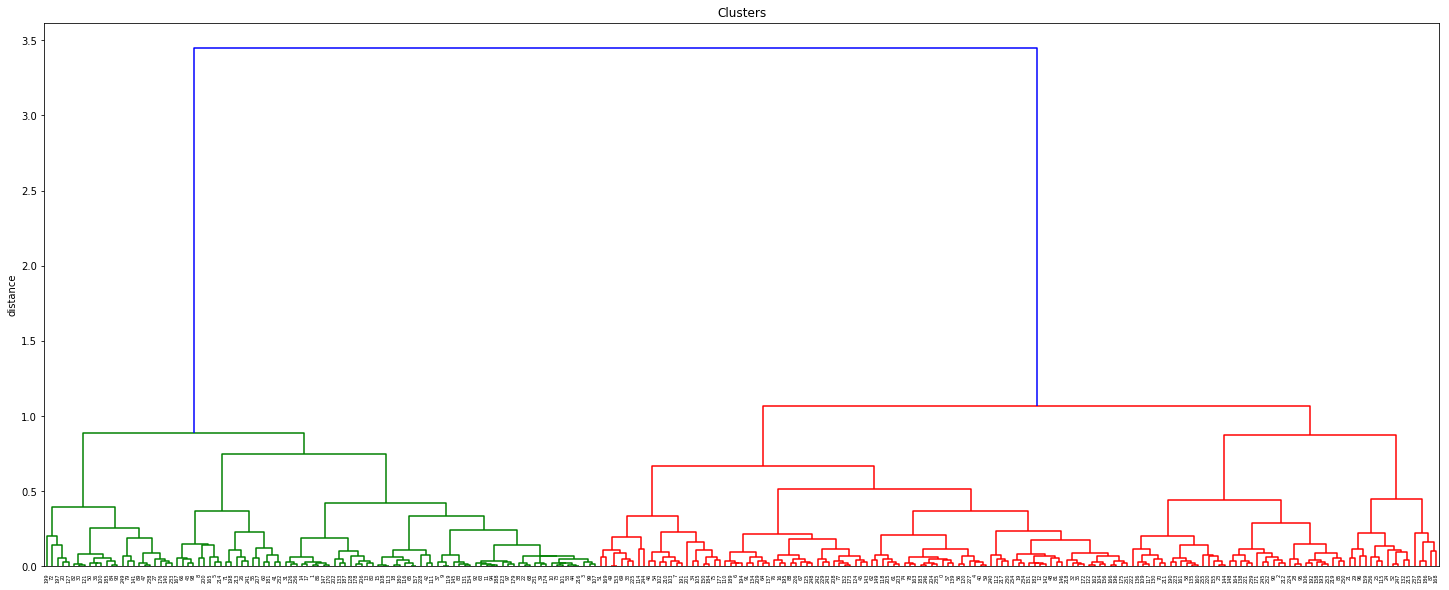

In [9]:
# Execute cluster dendogram
Z = linkage(sg_df,'ward')

plt.figure(figsize=(25,10))
plt.title('Clusters')
plt.ylabel('distance')
dendrogram(Z)

plt.axhline(y=15)
plt.show()